In [1]:
import sys
sys.path.append("../src")

In [19]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from ds.models import SkinstressionCNN
from types import SimpleNamespace
import collections
from PIL import Image
import numpy as np
from torchvision import transforms

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
class NestedNamespace(SimpleNamespace):
    """Sot that the stub config dictionary can be accessed by the model
    as if it was the hydra config file.
    """
    def __init__(self, dictionary, **kwargs):
        super().__init__(**kwargs)
        for key, value in dictionary.items():
            if isinstance(value, dict):
                self.__setattr__(key, NestedNamespace(value))
            else:
                self.__setattr__(key, value)

In [113]:
model_path = "/scistor/guest/sjg203/projects/shg-strain-stress/model_zoo/20.pt"
img_path = "/scistor/guest/sjg203/projects/shg-strain-stress/data/sorted/54/0.bmp"

In [114]:
cfg = {
    "params": {
        "model": {
            "n_nodes": 64,
            "num_output_features": 3
        }
}}
cfg = NestedNamespace(cfg)

In [115]:
model = SkinstressionCNN(cfg)
checkpoint = torch.load(model_path)
new_state_dict = collections.OrderedDict()
for k, v in checkpoint['model_state_dict'].items():
    name = k.replace("module.", '') # remove 'module.' prefix, because of bug in checkpoint saving.
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)
model = model.eval()
model = model.to(device)
# model = DataParallel(model)

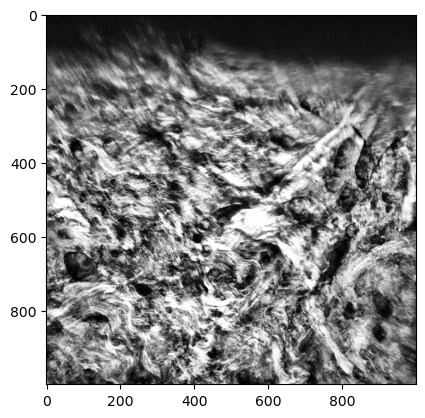

In [116]:
test_img = Image.open(img_path)
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data, cmap='gray', vmin=0, vmax=255)
plt.show()

In [117]:
# model expects 258x258
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((1000, 1000)),
        transforms.CenterCrop((700, 700)),
        transforms.Resize((258, 258)),
    ]
)

transformed_img = transform(test_img)
input_img = transformed_img.unsqueeze(0) # the model requires a dummy batch dimension

In [118]:
input_img = input_img.to(device)

In [119]:
list(model.children())

[Sequential(
   (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
   (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (6): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), bias=False)
   (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): ReLU()
   (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
   (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (12): ReLU()
   (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (14): Conv2d(64, 64, kernel_size=(6, 6), stride

In [120]:
model_weights = [] 
conv_layers = [] 
model_children = list(model.children())

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            child = model_children[i][j]
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 4


In [121]:
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 1, 3, 3])
CONV: Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 5, 5])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 64, kernel_size=(6, 6), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 6, 6])


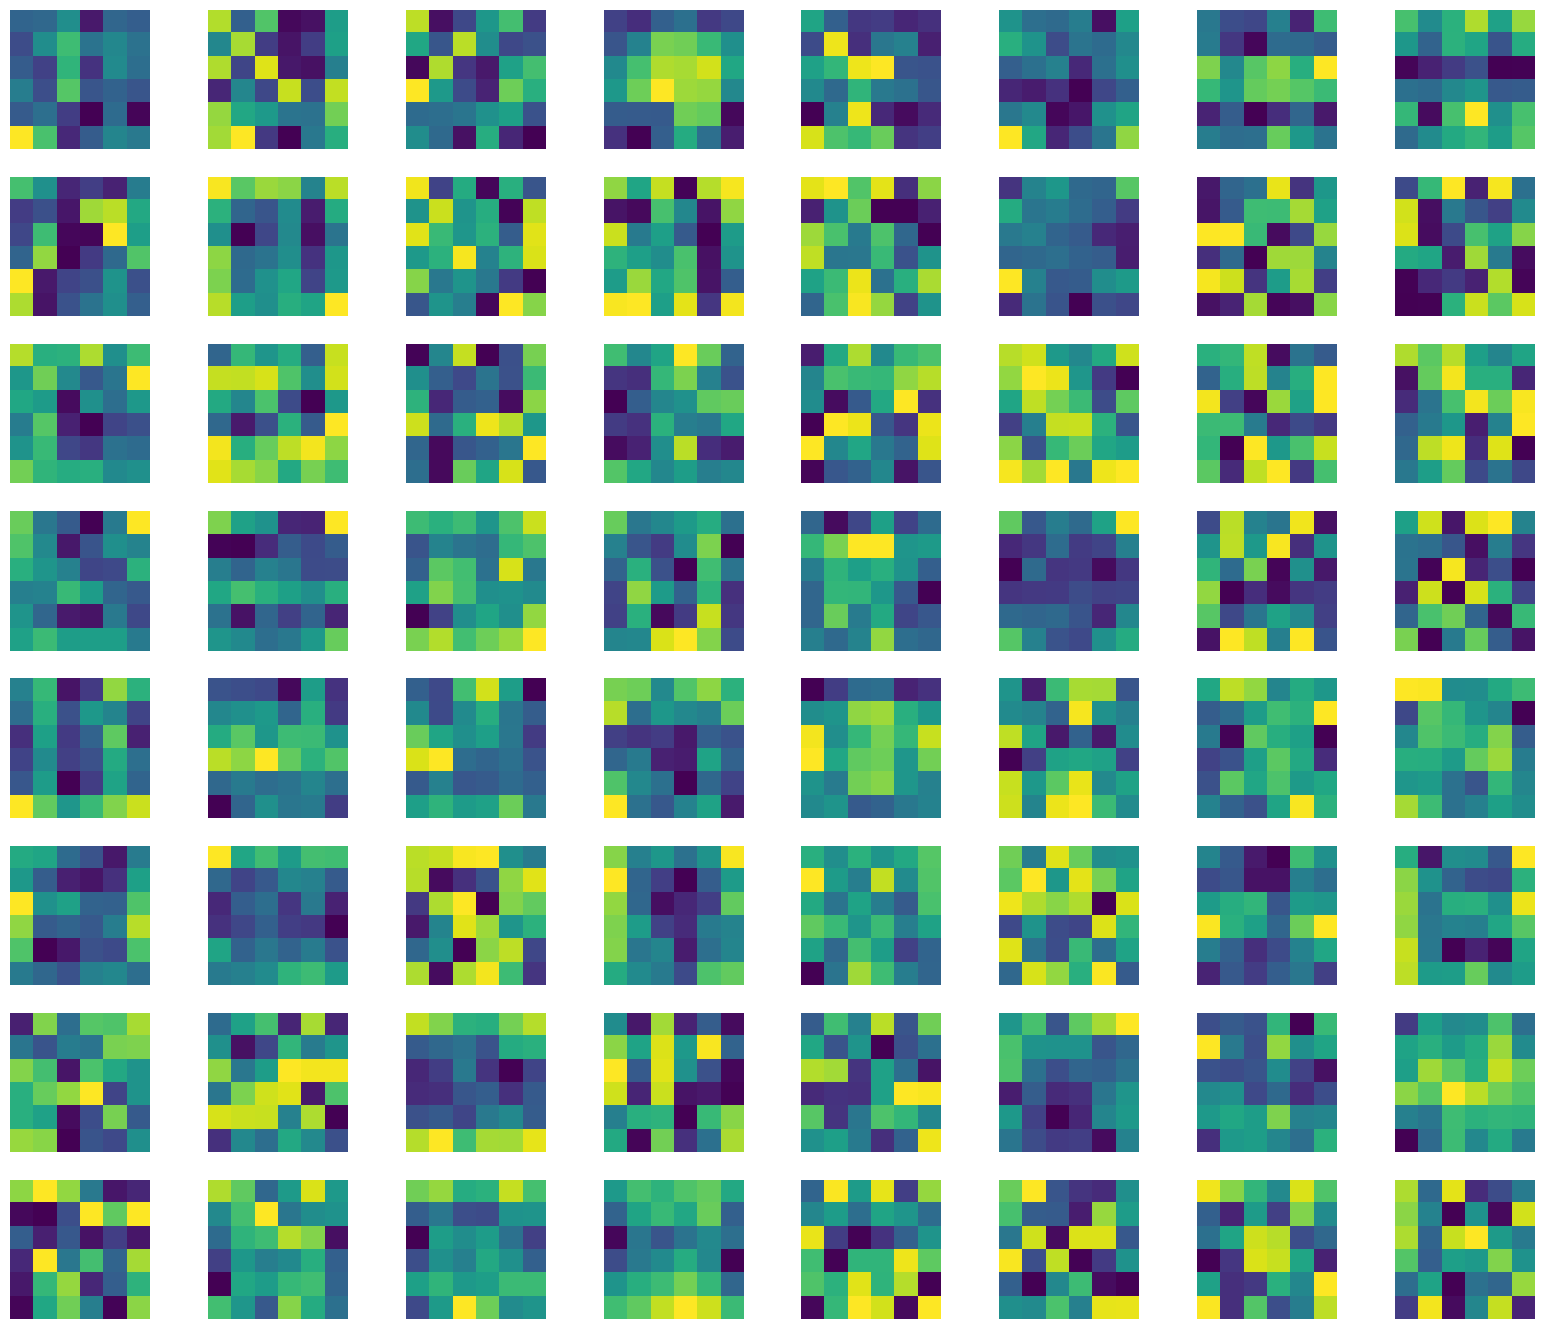

In [125]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
conv_layer_id = 3
for i, filter in enumerate(model_weights[conv_layer_id]):
    plt.subplot(8, 8, i+1)
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='viridis')
    plt.axis('off')
plt.savefig(f'outputs/filters/filter-{conv_layer_id}.pdf', bbox_inches="tight")
plt.show()

In [126]:
from torchvision.models.feature_extraction import get_graph_node_names
print(get_graph_node_names(model))

(['x', 'network.0', 'network.1', 'network.2', 'network.3', 'network.4', 'network.5', 'network.6', 'network.7', 'network.8', 'network.9', 'network.10', 'network.11', 'network.12', 'network.13', 'network.14', 'network.15', 'network.16', 'network.17', 'network.18', 'network.19', 'network.20', 'network.21'], ['x', 'network.0', 'network.1', 'network.2', 'network.3', 'network.4', 'network.5', 'network.6', 'network.7', 'network.8', 'network.9', 'network.10', 'network.11', 'network.12', 'network.13', 'network.14', 'network.15', 'network.16', 'network.17', 'network.18', 'network.19', 'network.20', 'network.21'])


/tmp/ipykernel_47727/411846932.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(8,8,figsize=(12, 15))


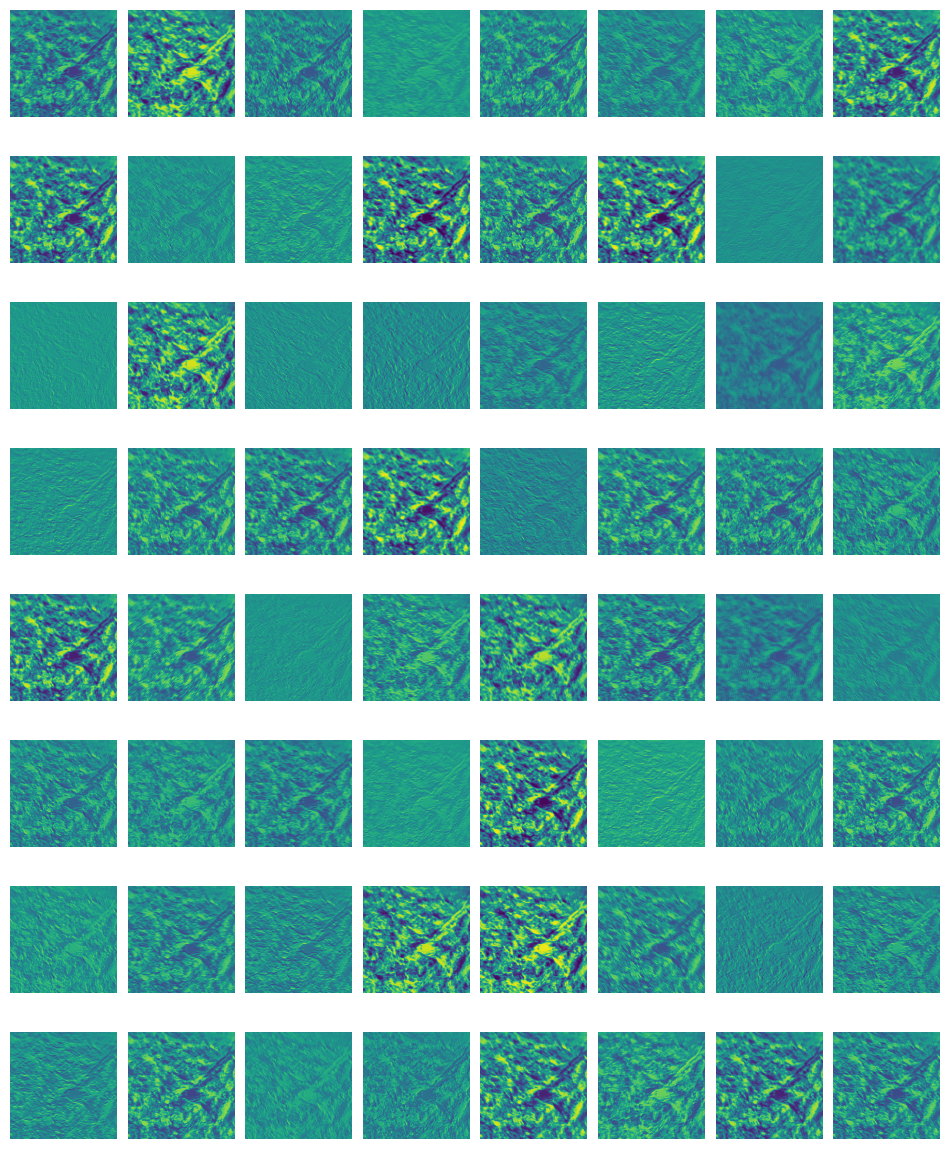

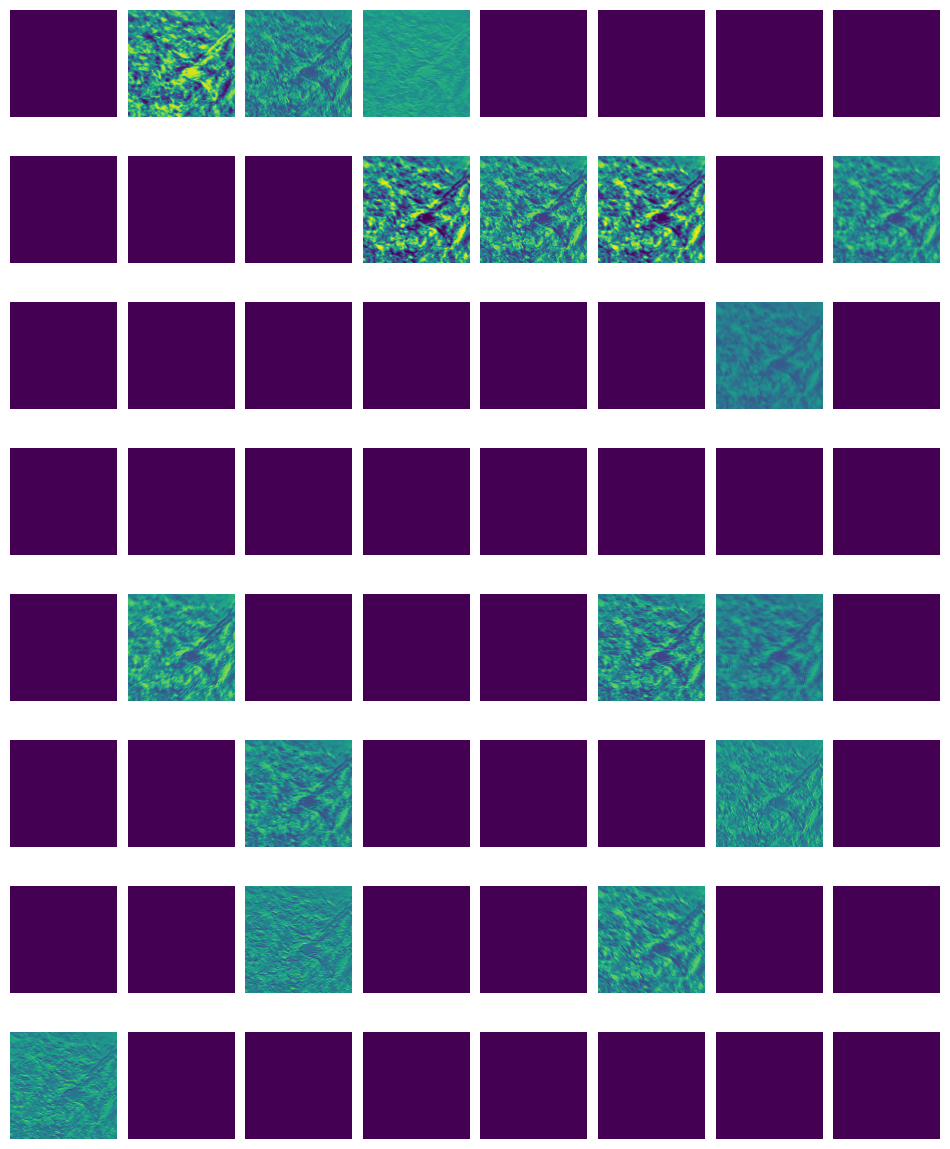

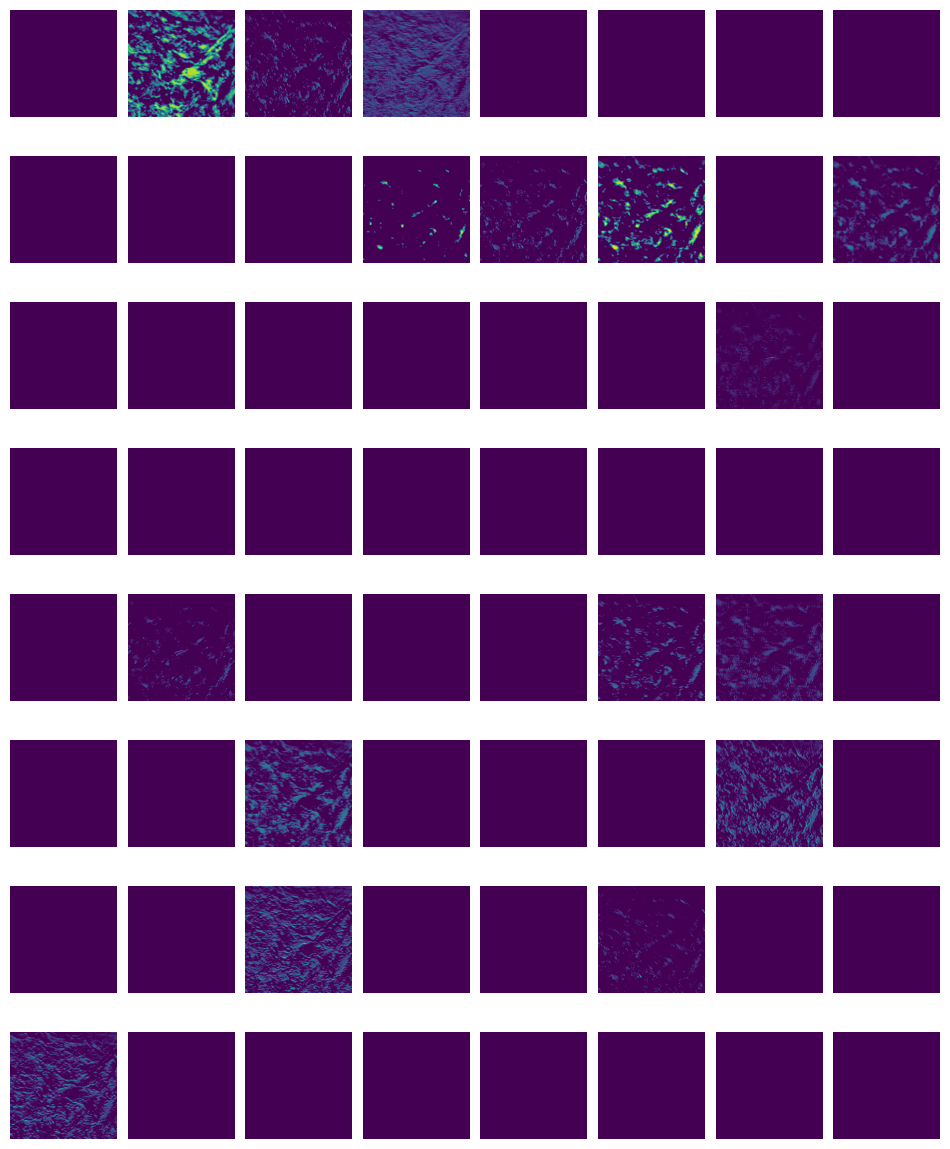

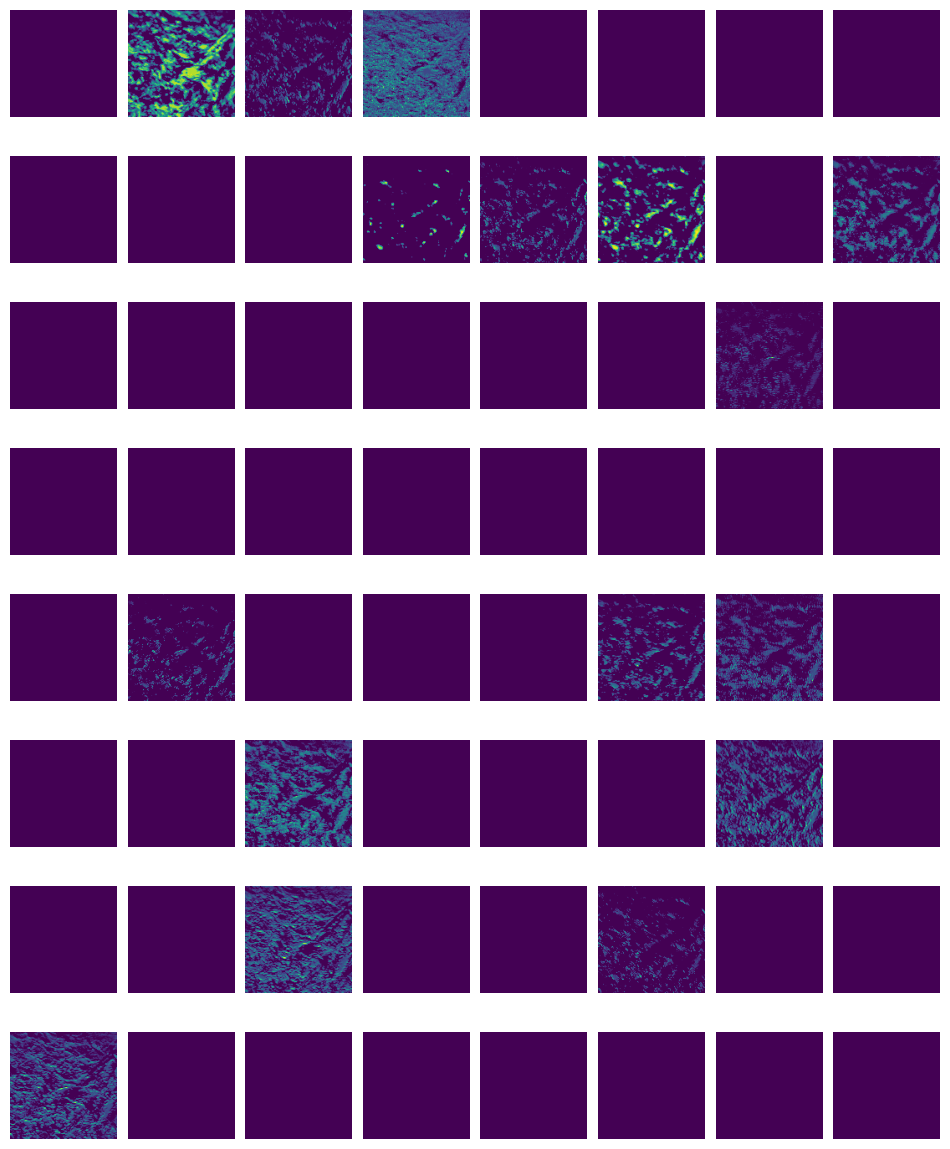

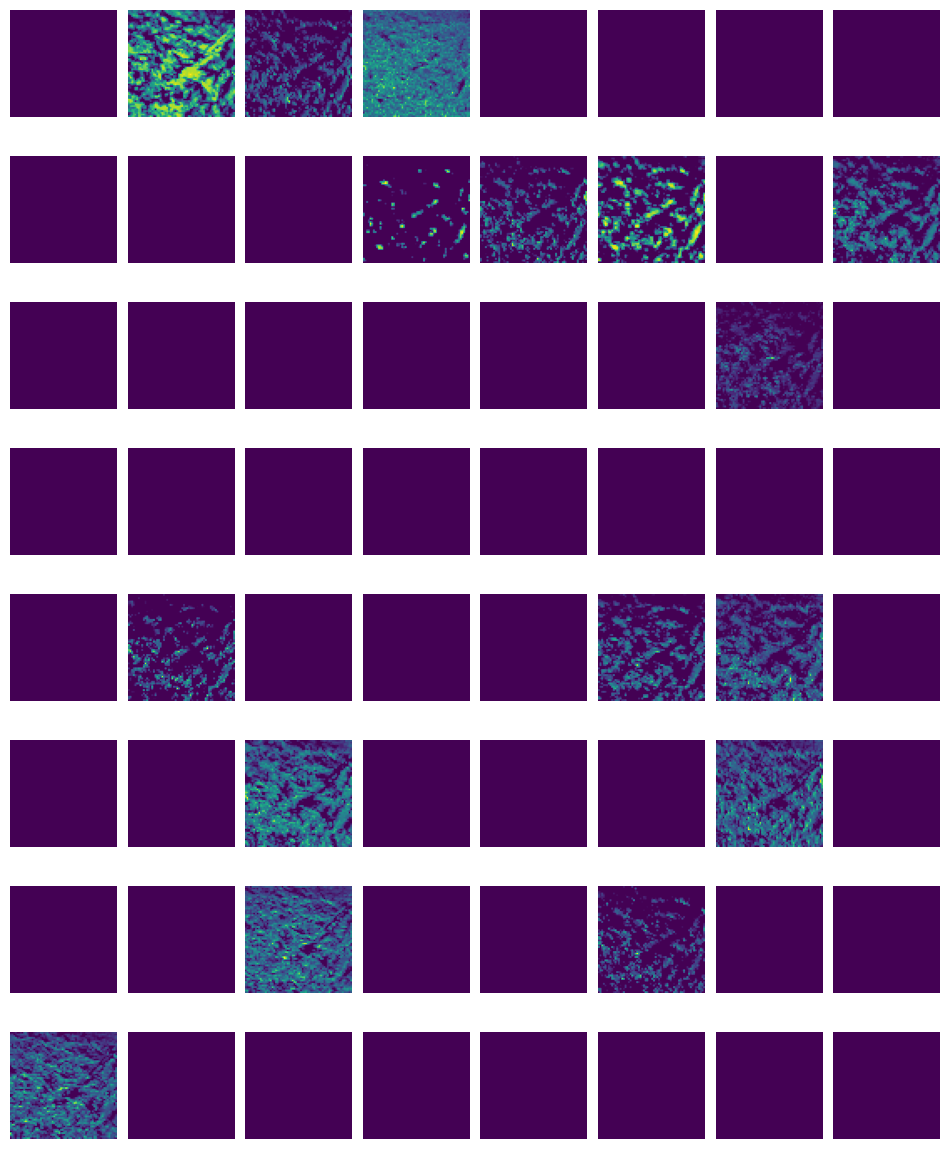

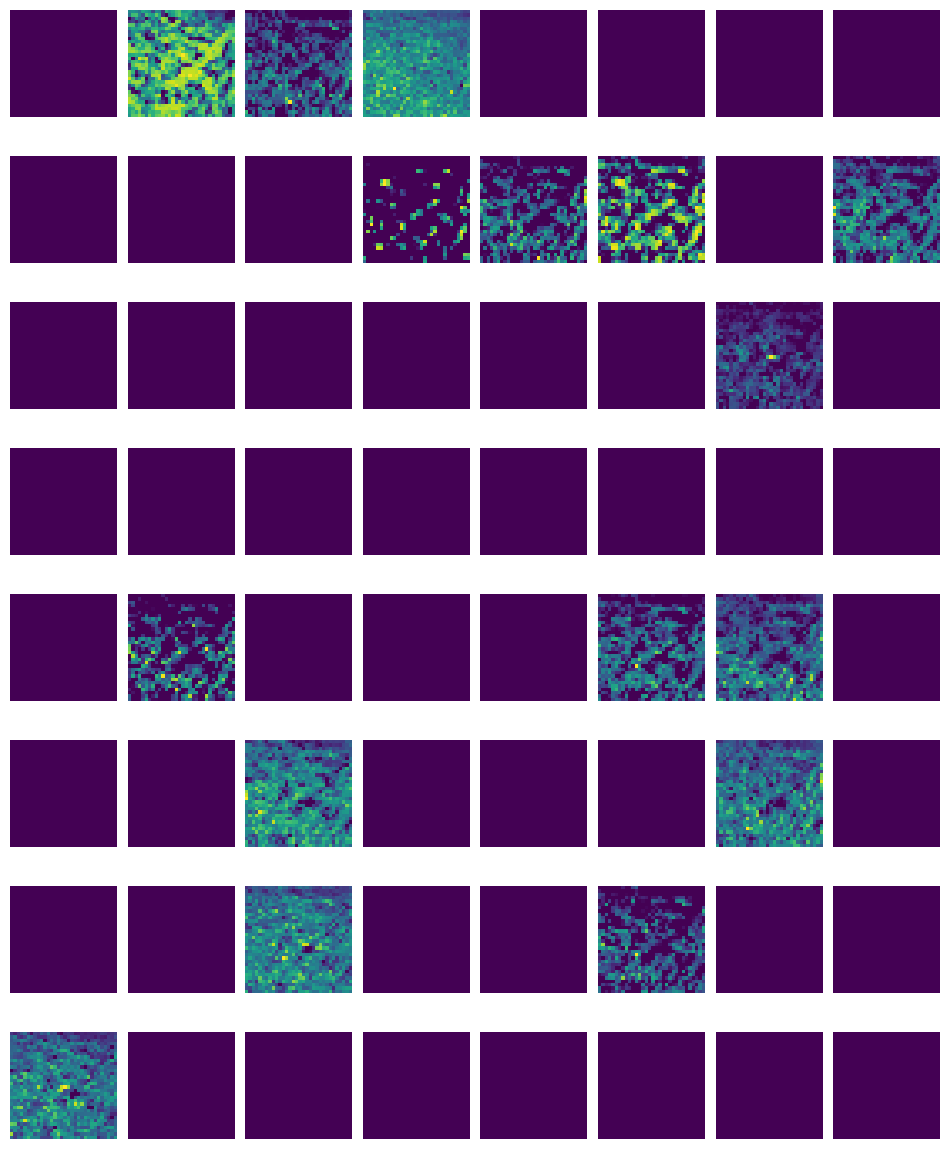

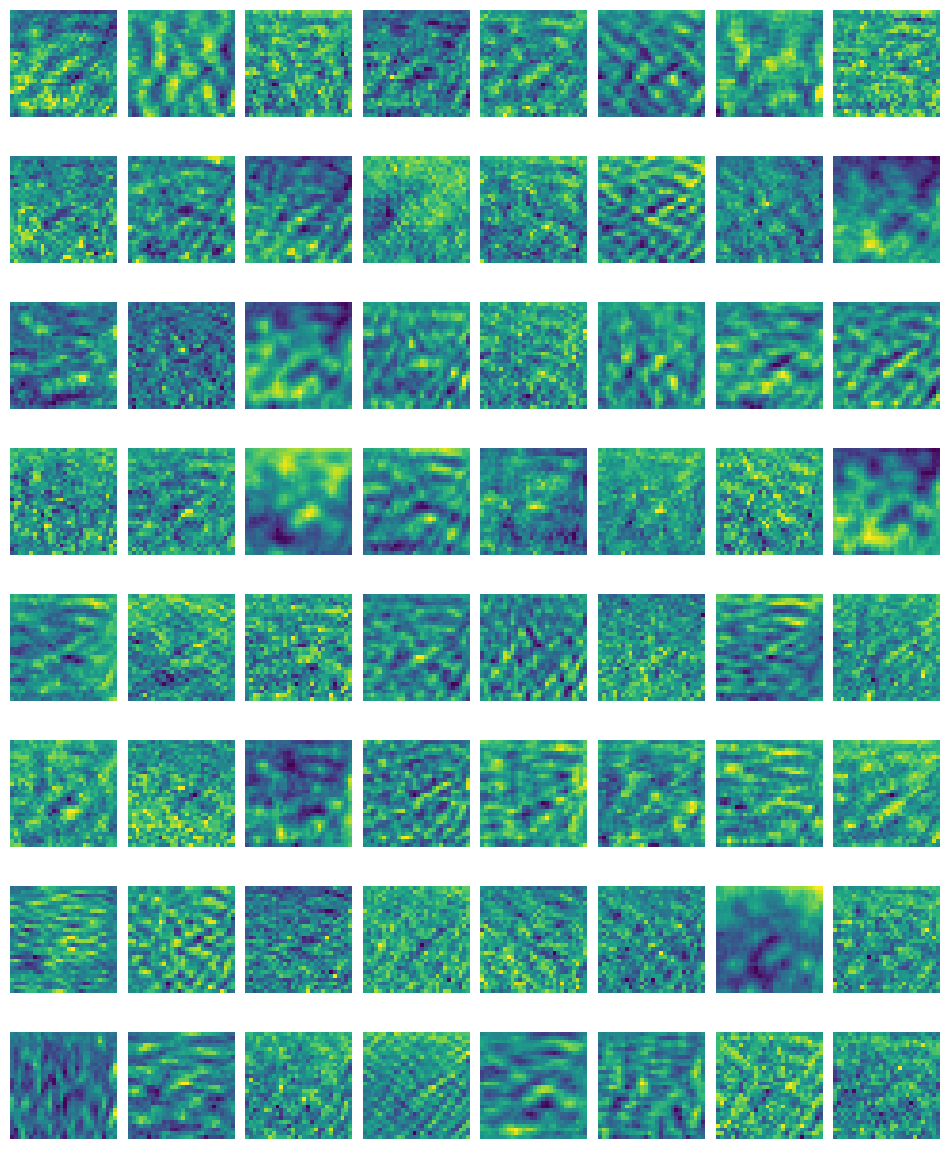

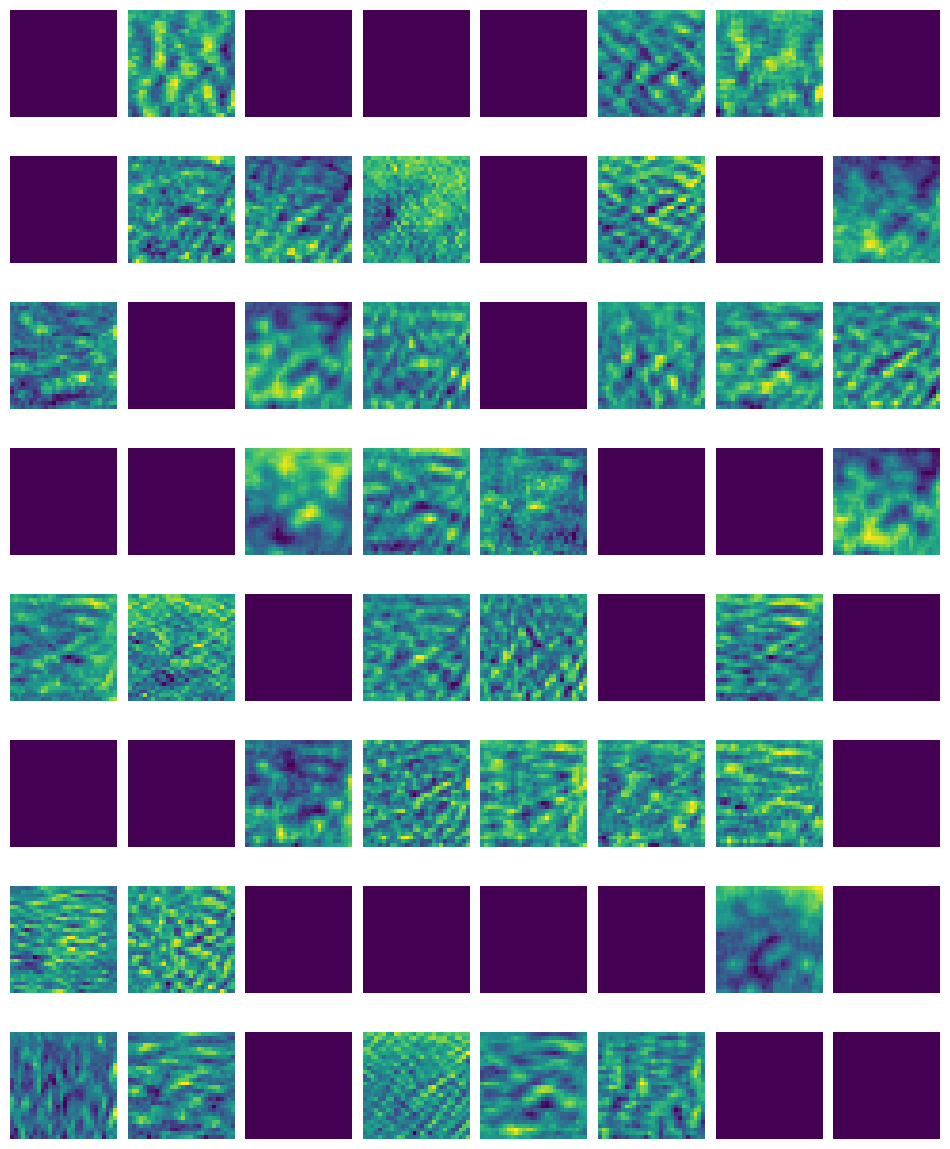

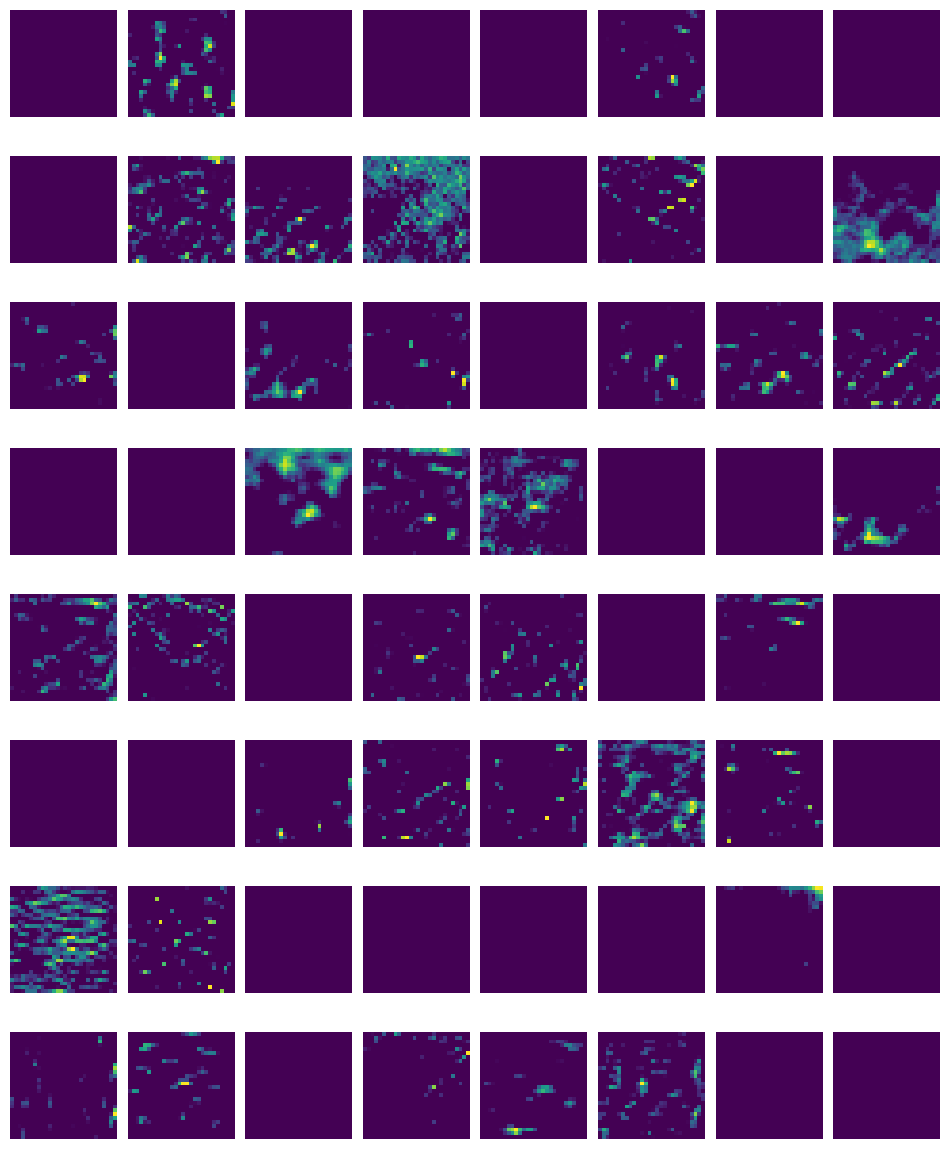

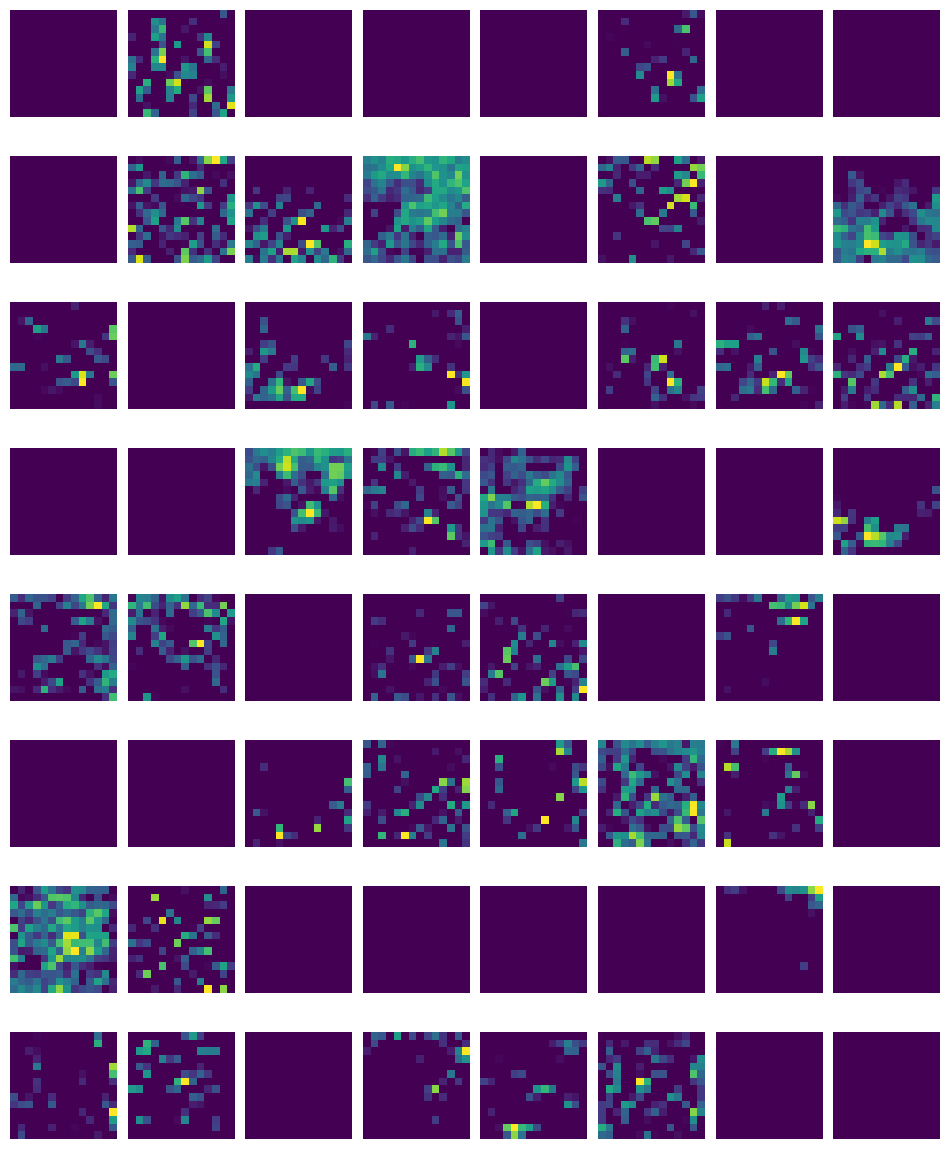

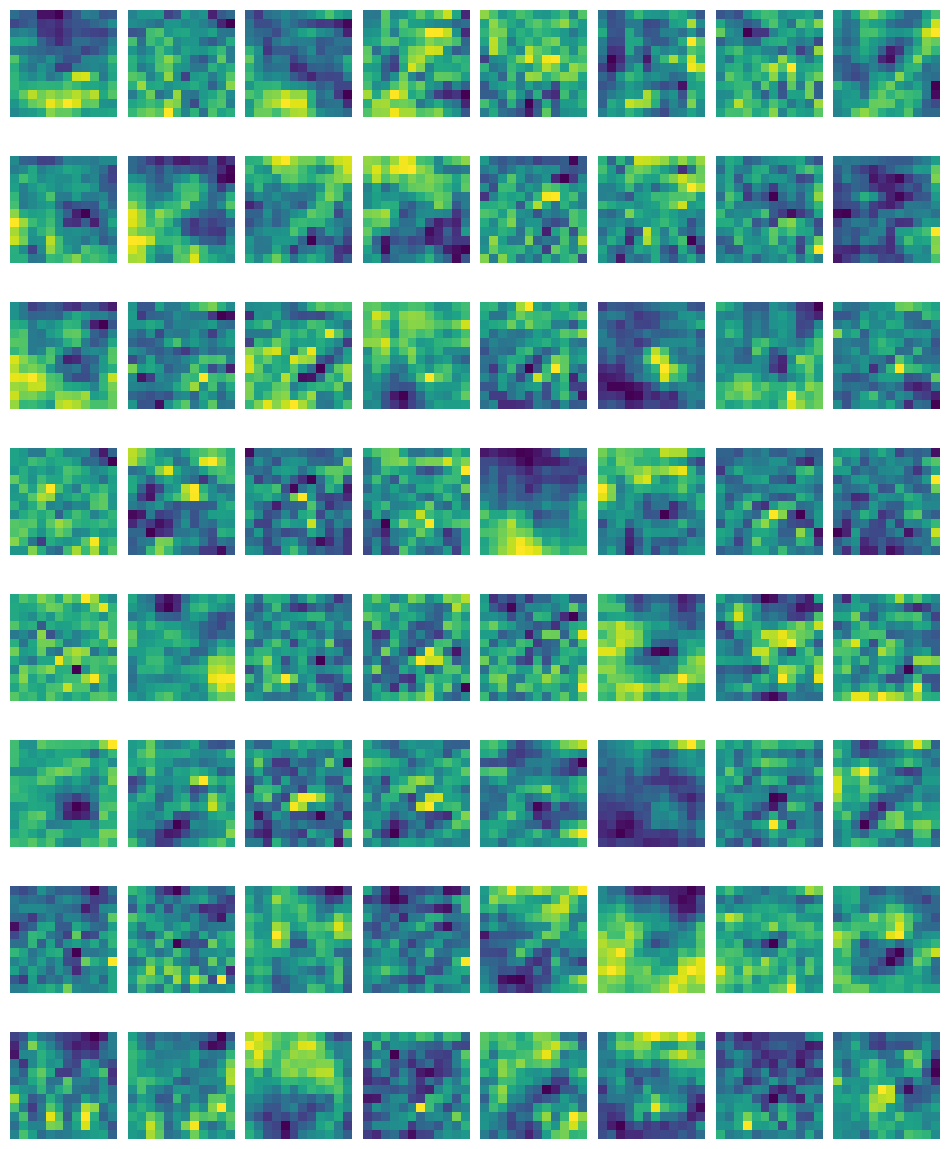

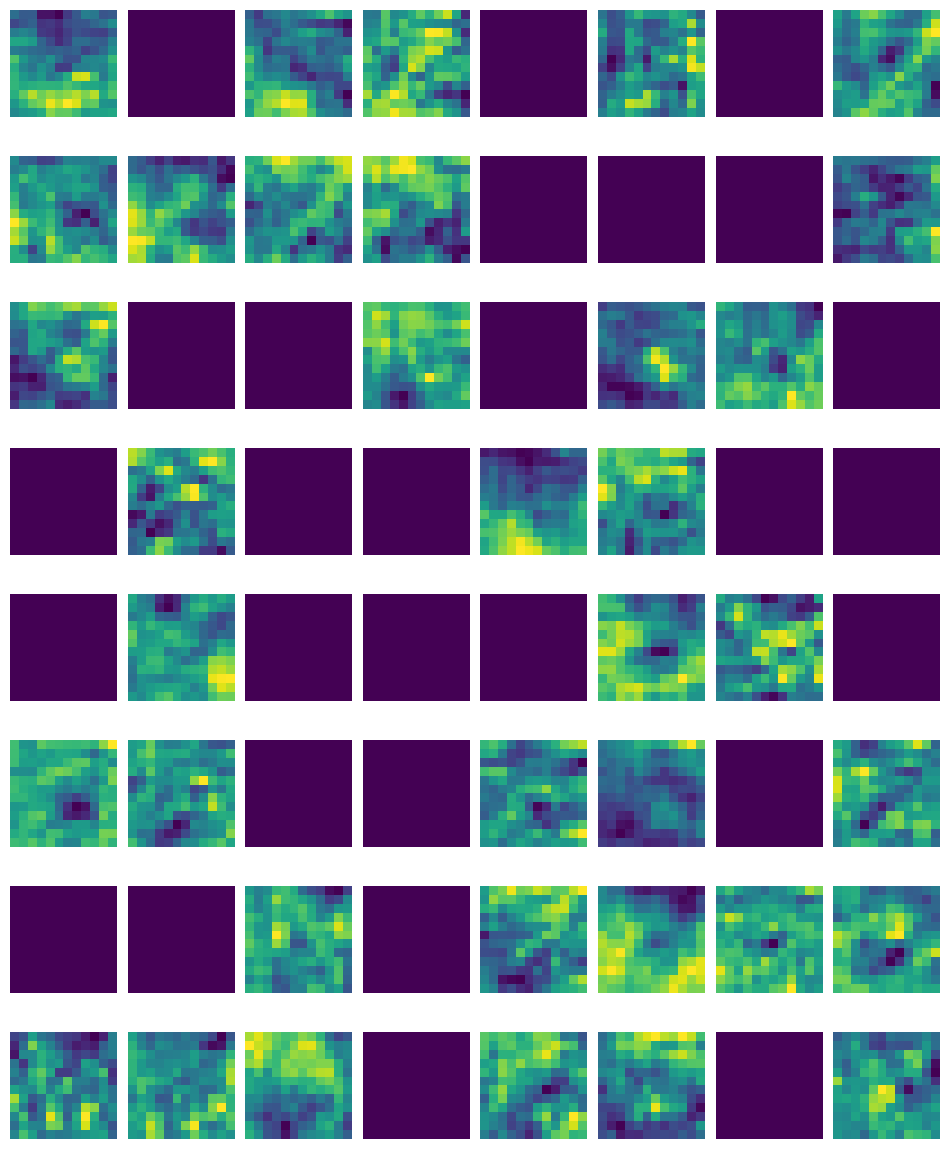

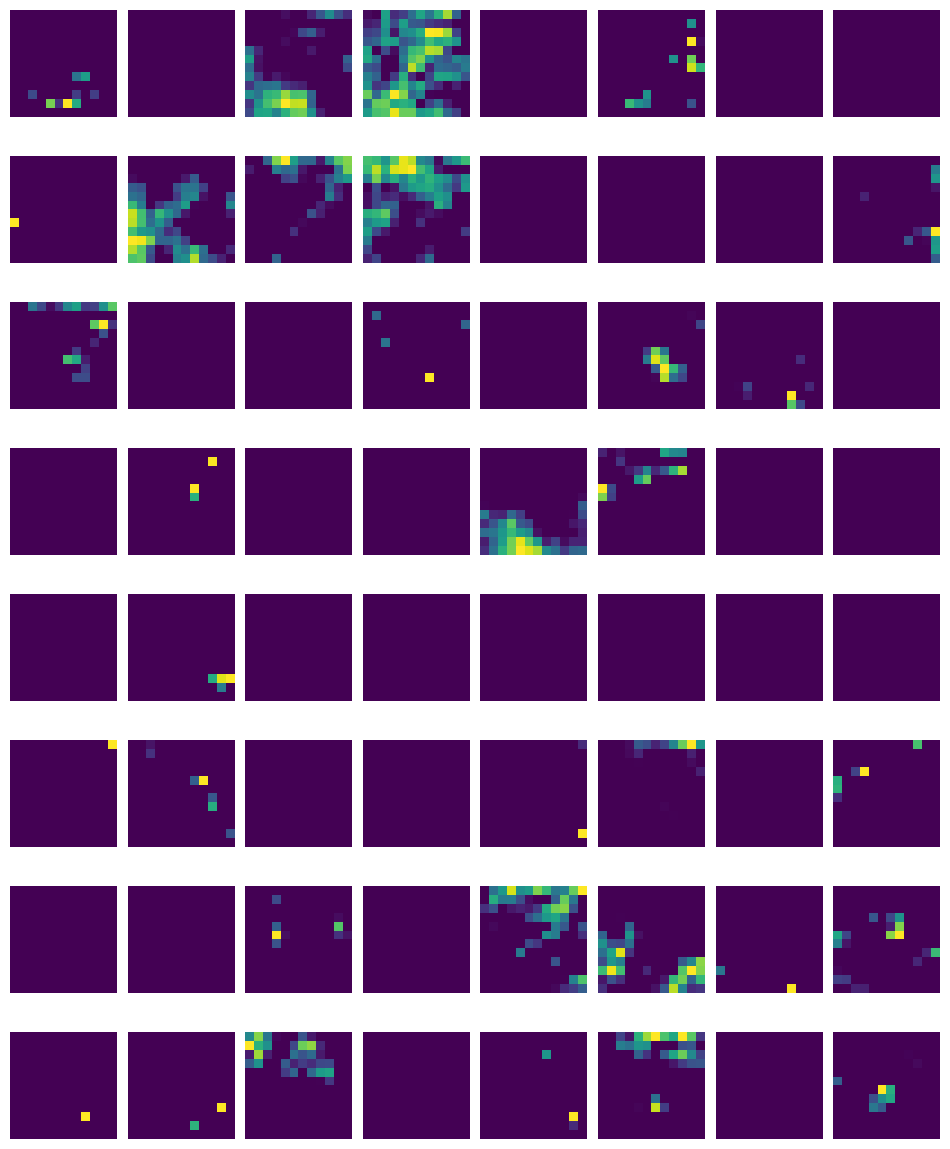

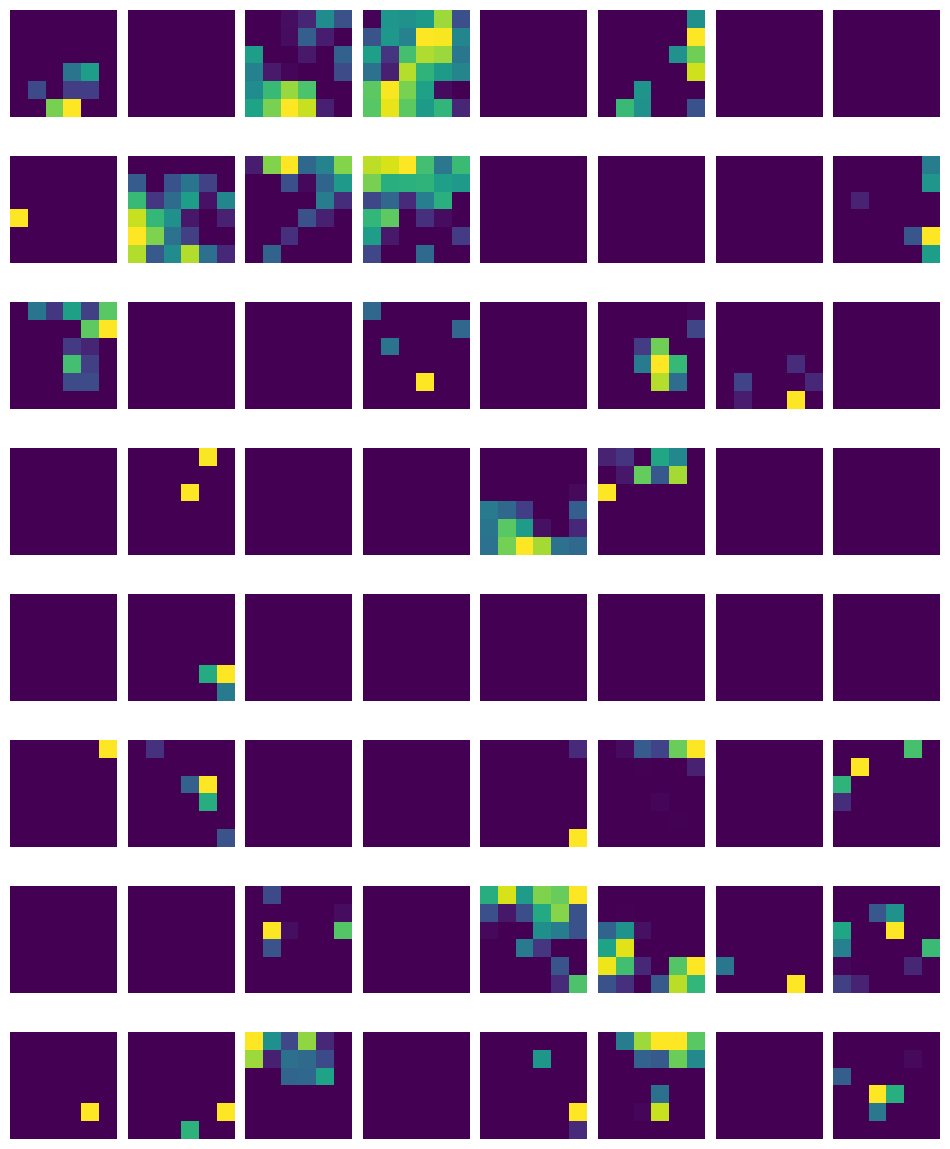

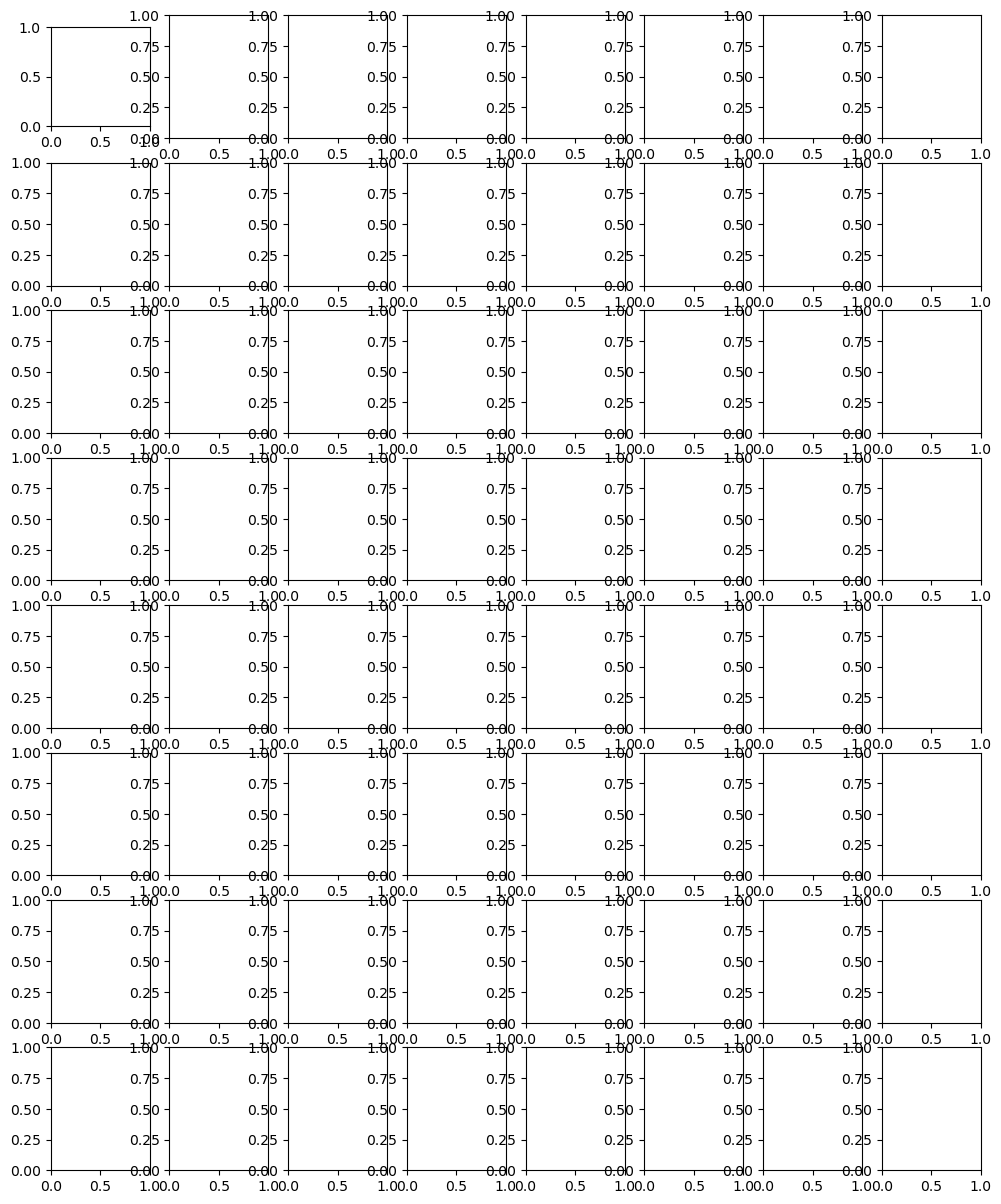

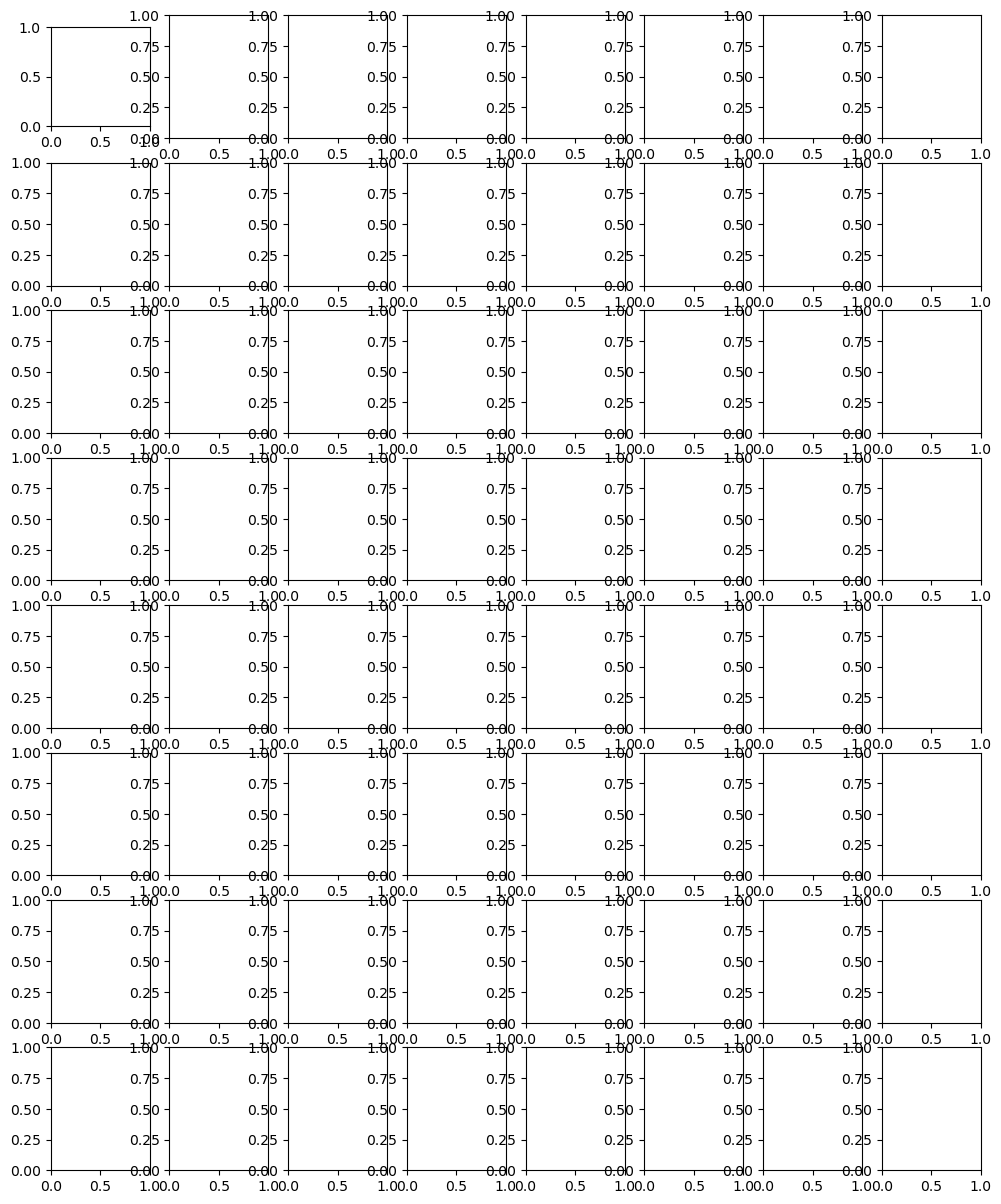

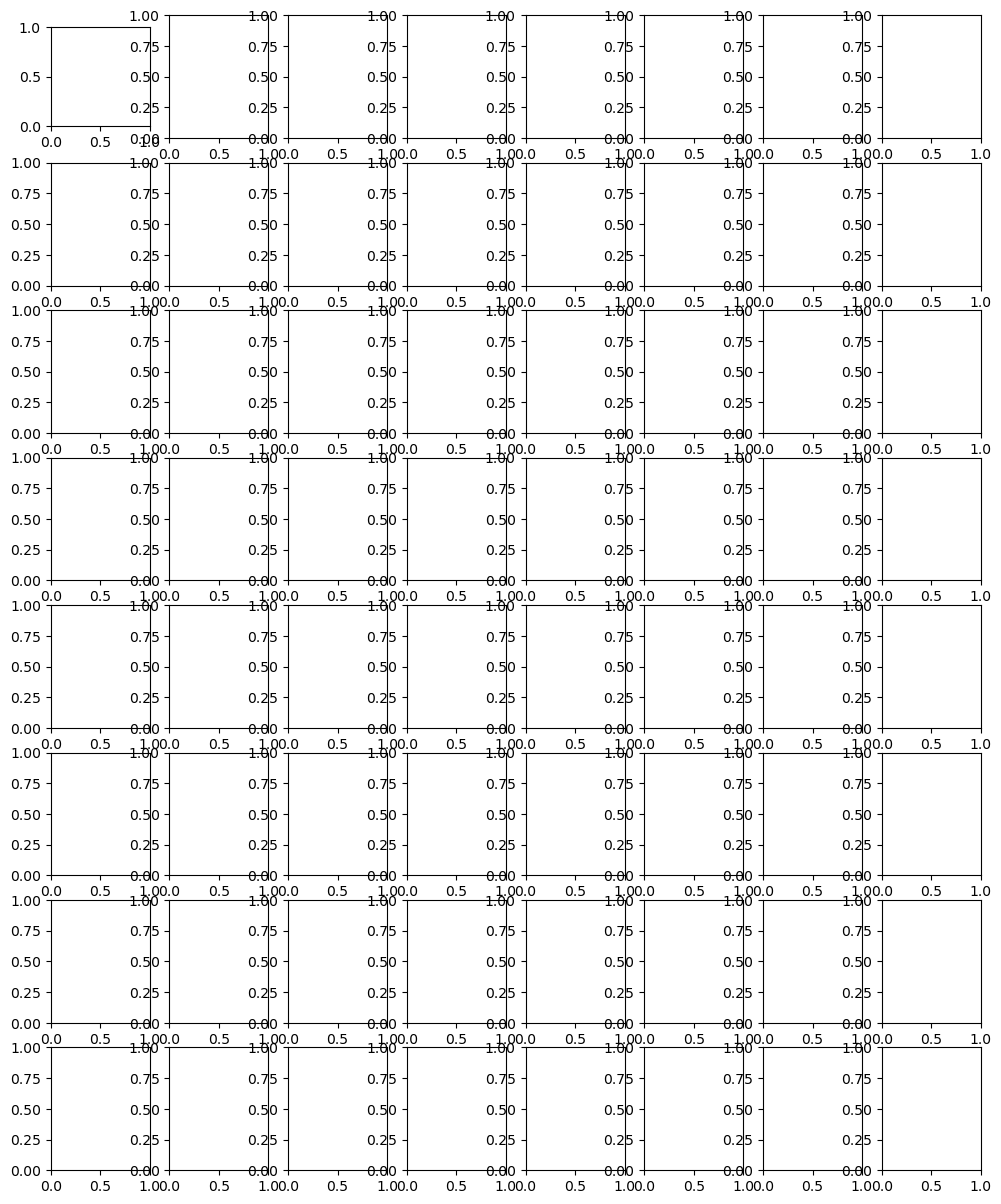

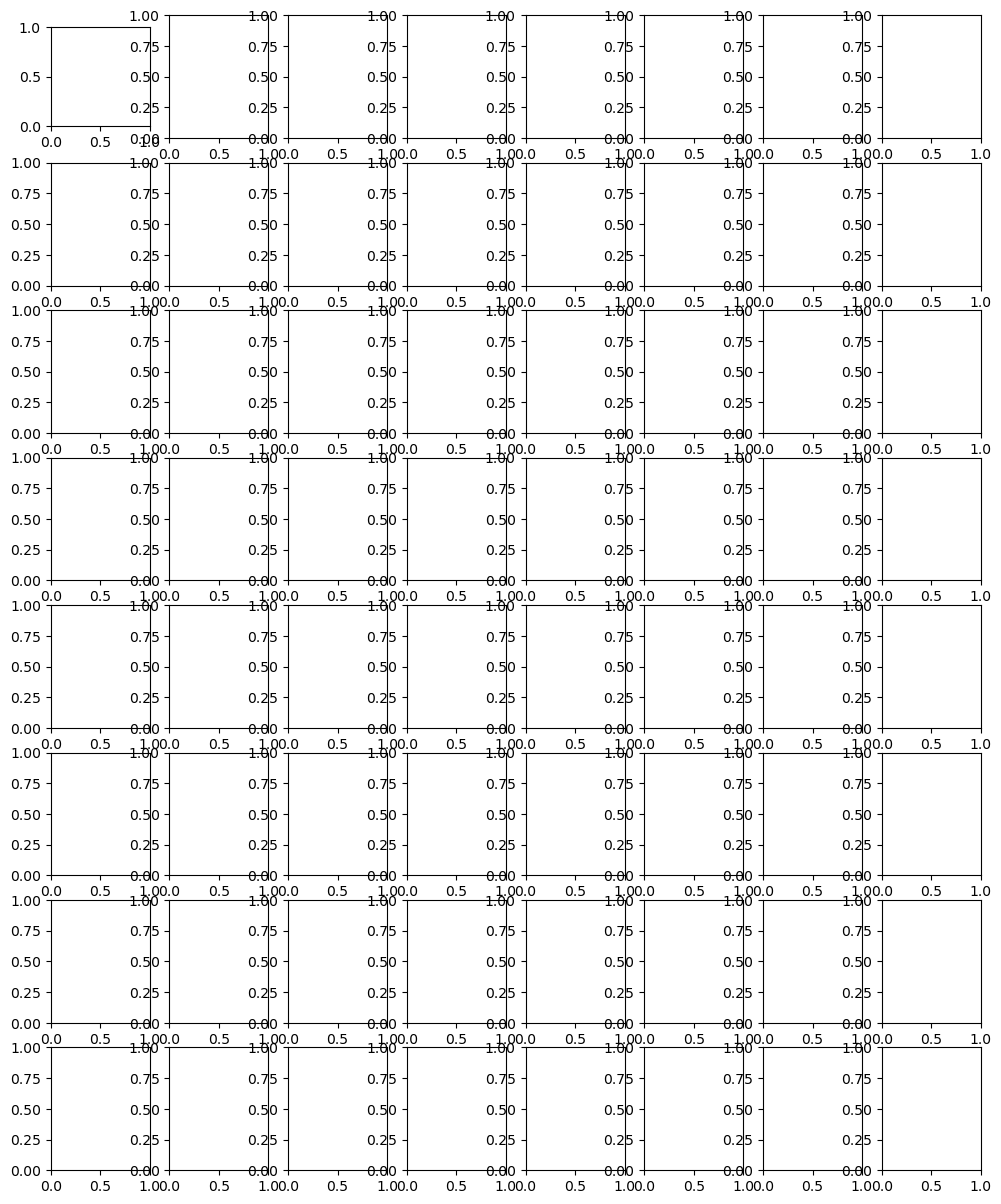

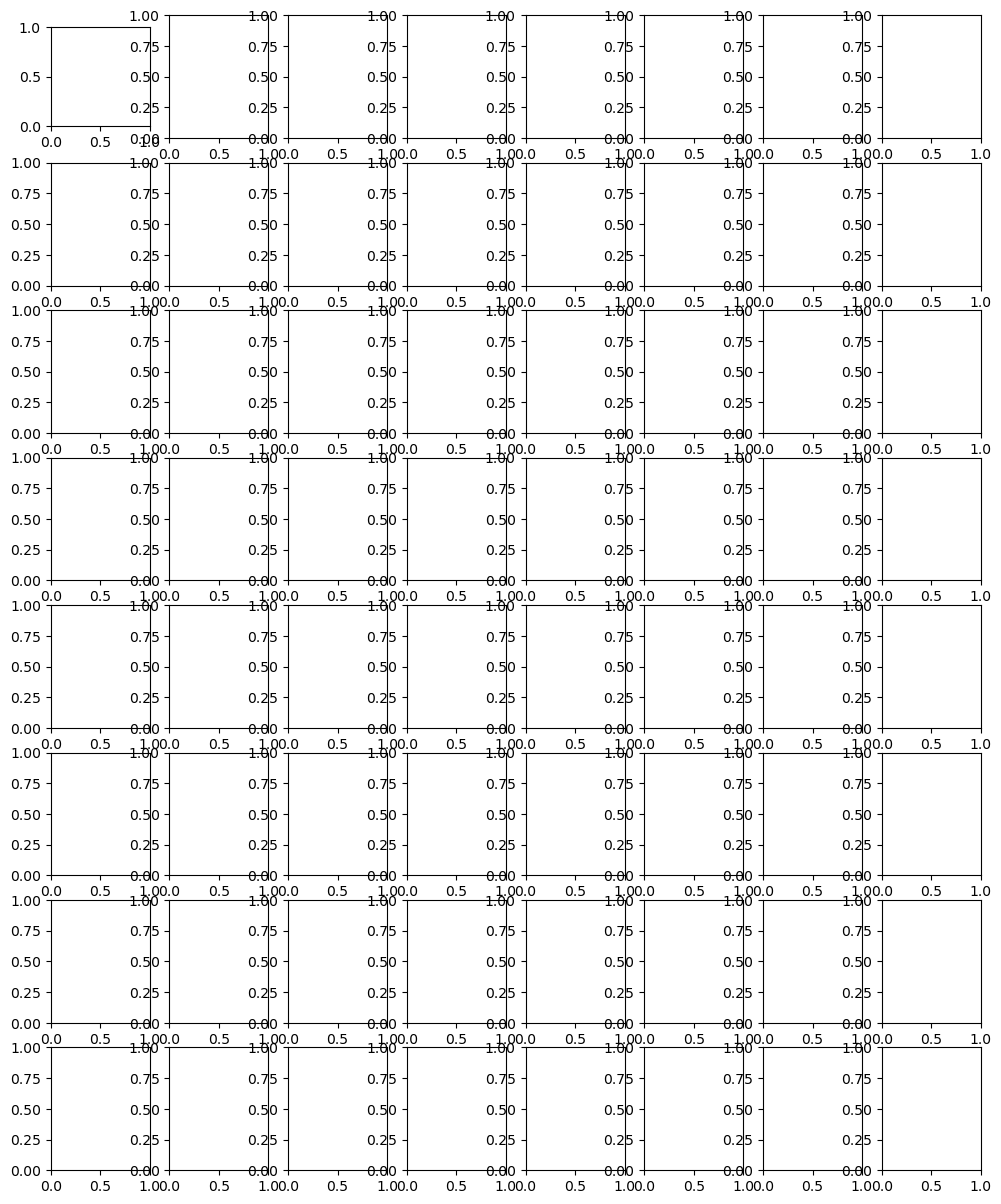

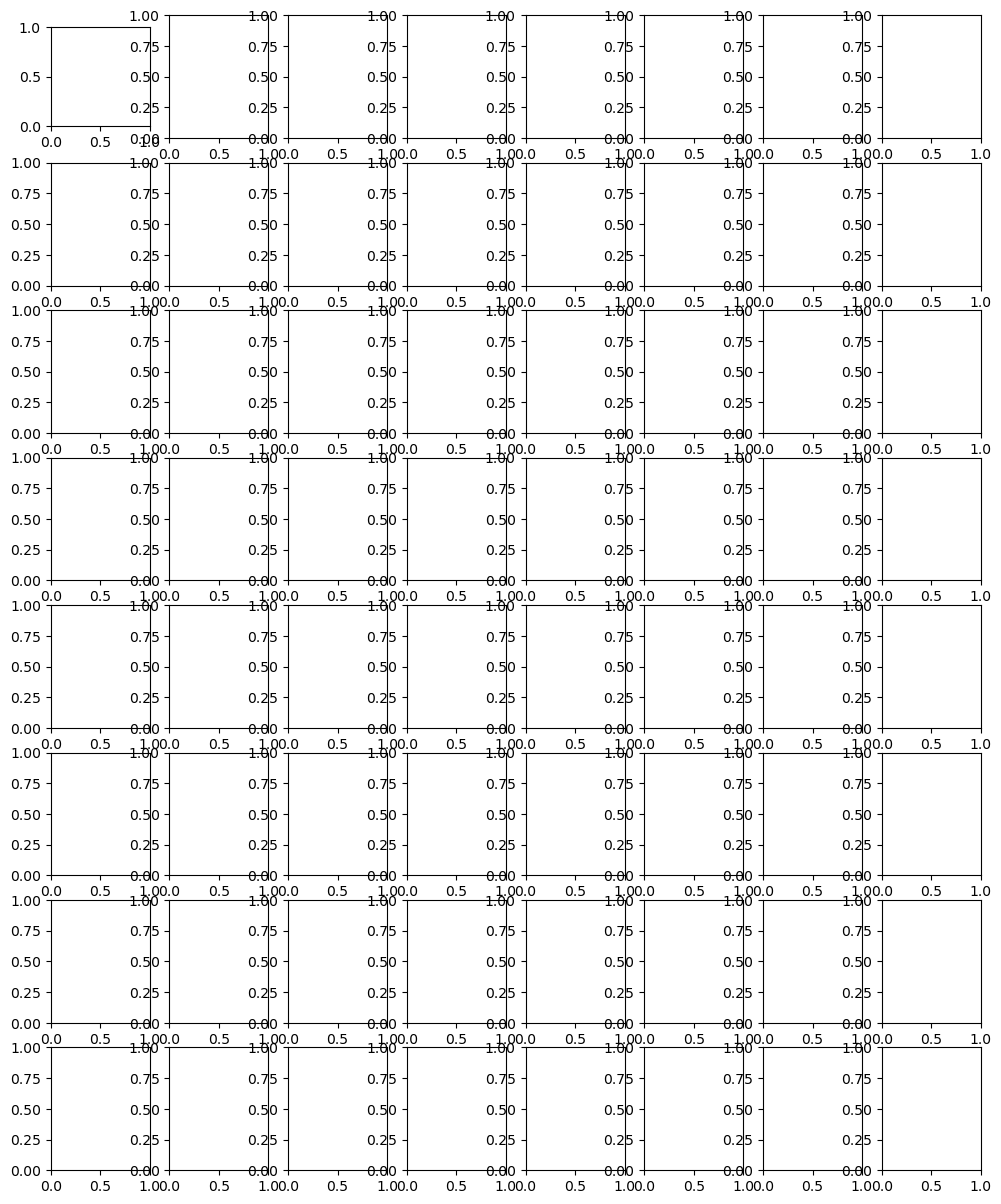

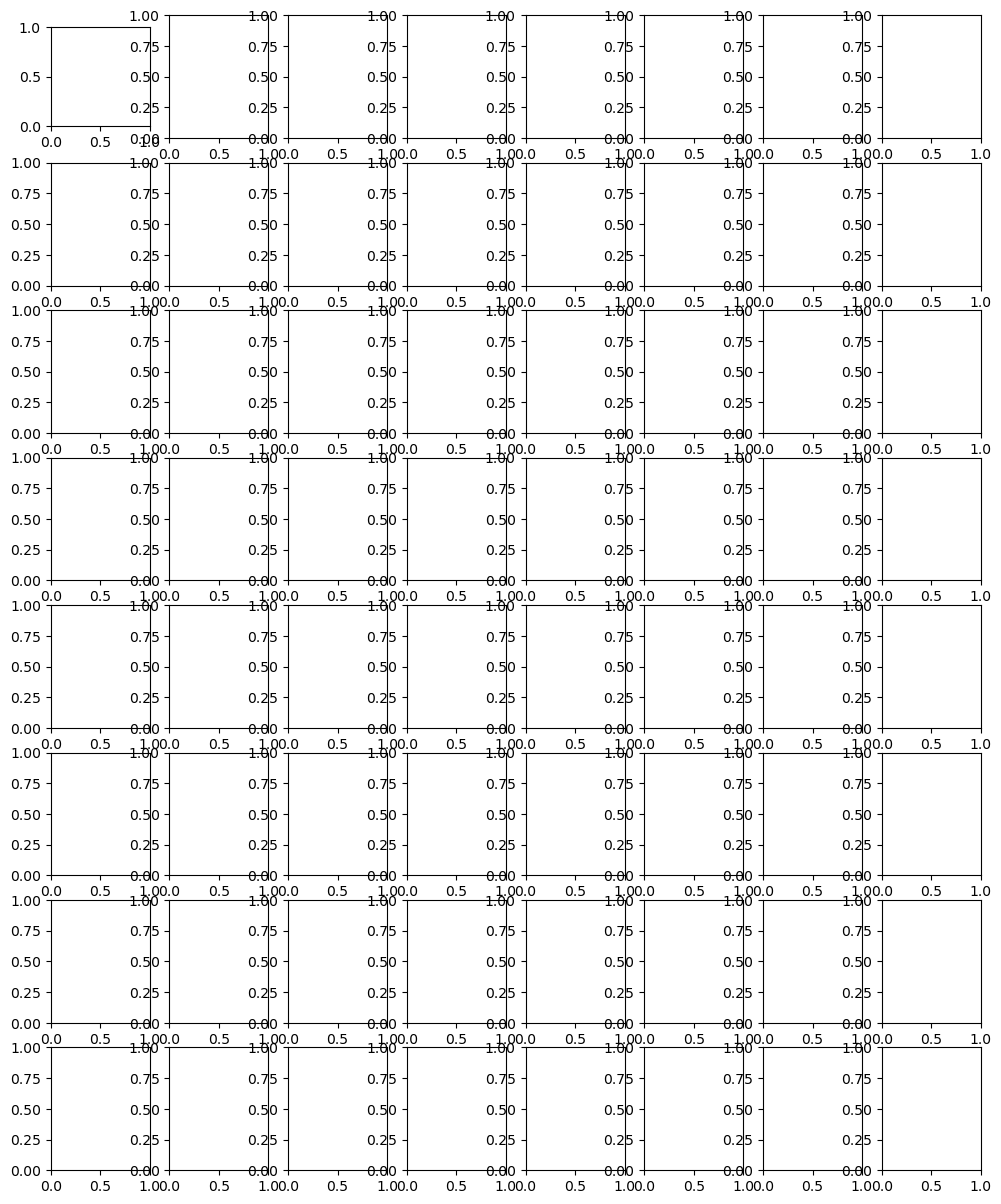

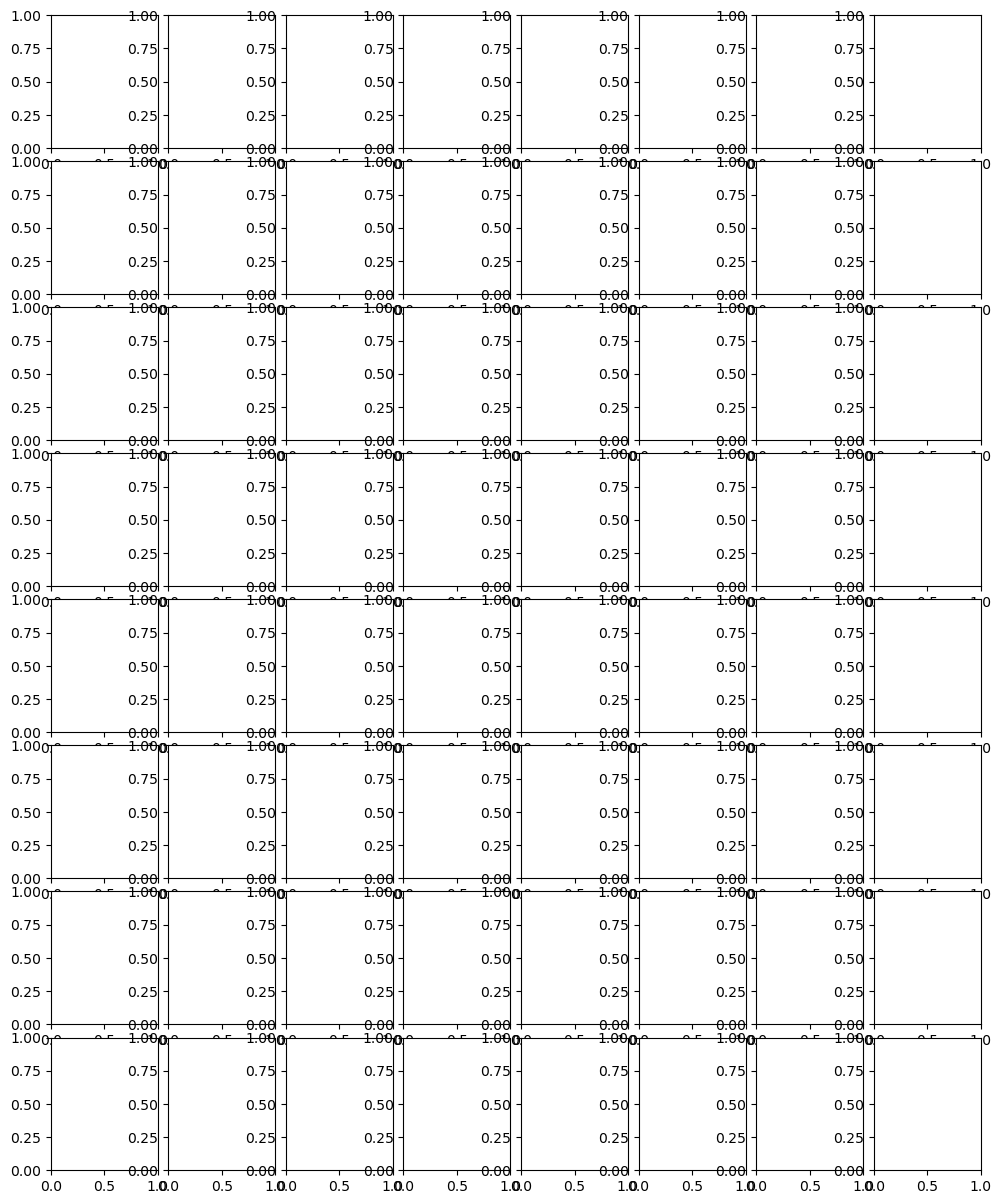

In [128]:
def output_activation_map(layer_id):
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    model.network[layer_id].register_forward_hook(get_activation(f'layer{layer_id + 1}'))
    _ = model(input_img)

    k=0
    act = activation[f'layer{layer_id + 1}'].squeeze()
    fig,ax = plt.subplots(8,8,figsize=(12, 15))

    for i in range(act.size(0)//8):
        for j in range(act.size(0)//8):
            ax[i,j].imshow(act[k].detach().cpu().numpy())
            ax[i,j].set_axis_off()
            k+=1
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    # plt.show()
    plt.savefig(f'outputs/featuremaps/layer{layer_id + 1}.pdf', bbox_inches="tight")

for i in range(22):
    try:
        output_activation_map(i)
    except TypeError:
        continue